# Deep Learning – Classification (PyTorch)

This notebook is part of the **ML-Methods** project.

It introduces **Deep Learning for supervised classification**
using **PyTorch**, a low-level and flexible deep learning framework.

As with the other classification notebooks,
the first sections focus on data preparation
and are intentionally repeated.

This ensures consistency across models
and allows fair comparison of results.

-----------------------------------------------------

## Notebook Roadmap (standard ML-Methods)

1. Project setup and common pipeline  
2. Dataset loading  
3. Train-test split  
4. Feature scaling (why we do it)  

----------------------------------

5. What is this model? (Intuition)  
6. Model training  
7. Model behavior and key parameters  
8. Predictions  
9. Model evaluation  
10. When to use it and when not to  
11. Model persistence  
12. Mathematical formulation (deep dive)  
13. Final summary – Code only  

-----------------------------------------------------

## How this notebook should be read

This notebook is designed to be read **top to bottom**.

Before every code cell, you will find a short explanation describing:
- what we are about to do
- why this step is necessary
- how it fits into the overall process

Compared to scikit-learn,
this notebook exposes **more internal details**
of how a Deep Learning model is trained.

The goal is not only to run the code,
but to understand **what happens during training**
and how neural networks learn step by step.

-----------------------------------------------------

## What is Deep Learning (in this context)?

Deep Learning refers to a class of models
based on **neural networks with multiple layers**.

These models are designed to:
- learn complex, non-linear relationships
- build internal representations of the data
- improve performance as data complexity increases

In this notebook, we focus on:
**Deep Learning for tabular classification**
using fully connected neural networks.

-----------------------------------------------------

## Why PyTorch?

PyTorch is a **low-level deep learning framework**
that provides explicit control over:

- model architecture
- forward pass
- loss computation
- backpropagation
- parameter updates

Unlike scikit-learn:
- nothing is hidden
- every step must be defined explicitly

This makes PyTorch ideal for:
- learning how neural networks actually work
- understanding gradient-based optimization
- experimenting with custom architectures

-----------------------------------------------------

## Execution model: eager execution

PyTorch uses **eager execution** by default.

This means:
- operations are executed immediately
- tensors behave like regular Python objects
- debugging is straightforward

Eager execution makes PyTorch:
- intuitive to learn
- flexible to experiment with
- closer to the mathematical description of the model

-----------------------------------------------------

## What you should expect from the results

With Deep Learning (PyTorch), you should expect:

- non-linear decision boundaries
- strong performance on complex data
- behavior similar to scikit-learn neural networks
- higher transparency during training

However:
- more code is required
- implementation errors are easier to make
- careful design is necessary

-----------------------------------------------------


## 1. Project setup and common pipeline

In this section we set up the common pipeline
used across classification models in this project.

Although this notebook uses **PyTorch**,
the overall workflow remains identical
to the scikit-learn Deep Learning notebook.

This allows us to:
- reuse the same data preparation steps
- compare models fairly
- isolate the effect of the framework choice


In [1]:
# Common imports used across classification models

import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

from pathlib import Path
import matplotlib.pyplot as plt

# ====================================
# PyTorch imports
# ====================================

import torch
import torch.nn as nn
import torch.optim as optim


### What changes with PyTorch

Compared to scikit-learn:
- the pipeline structure remains the same
- data preparation and evaluation stay unchanged
- only the model implementation differs

With PyTorch, we explicitly define:
- how the model processes the input
- how the loss is computed
- how parameters are updated

Nothing is hidden.

Every step of the learning process
is written manually in code.

This makes PyTorch ideal
for understanding what neural networks
are actually doing during training.

In the next section,
we will load the dataset
and prepare it for PyTorch training.


____________
## 2. Dataset loading

In this section we load the dataset
used for the Deep Learning classification task.

We intentionally use the **same dataset**
adopted in previous classification notebooks.

This ensures:
- direct comparison with classical ML models
- fair comparison across deep learning frameworks
- focus on implementation differences, not on data


In [2]:
# ====================================
# Dataset loading
# ====================================

data = load_breast_cancer(as_frame=True)

X = data.data
y = data.target


### What we have after this step

- `X` contains the input features
- `y` contains the target labels

This is a **binary classification problem**,
where each sample belongs to one of two classes.

At this stage:
- data is still in NumPy / pandas format
- this is intentional for consistency
- conversion to PyTorch tensors will happen later

In the next section,
we will split the dataset
into training and test sets.


_______________
## 3. Train-test split

In this section we split the dataset
into training and test sets.

This step allows us to evaluate
how well the neural network generalizes
to unseen data.


In [3]:
# ====================================
# Train-test split
# ====================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


### What we have after this step

After splitting the data:
- the training set is used to learn model parameters
- the test set is kept completely unseen
- evaluation reflects real-world performance

An 80 / 20 split is a common default
for medium-sized datasets.

In the next section,
we will apply **feature scaling**.

For Deep Learning models,
this step is **mandatory**.


_____________
## 4. Feature scaling (why we do it)

In this section we apply feature scaling
to the input data.

For Deep Learning models,
feature scaling is **mandatory**.

Neural networks rely on gradient-based optimization,
which is highly sensitive to feature scale.


In [4]:
# Feature scaling

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Why we use standardization here

We use **standardization** for feature scaling
because neural networks are trained
using gradient-based optimization.

Standardization:
- centers features around zero
- ensures comparable feature variance
- improves numerical stability during training

This helps:
- gradients behave more predictably
- optimization converge faster
- training remain stable across layers

For Deep Learning models,
this preprocessing choice is part of the model design,
not just a data transformation.


### Why scaling is essential here

Without proper scaling:
- gradients may vanish or explode
- optimization becomes unstable
- training may converge very slowly or fail

By scaling the features:
- all inputs are brought to a comparable range
- gradient descent becomes more stable
- learning is faster and more reliable

At this point:
- data is numerically ready
- but still in NumPy format

In the next section,
we will explain **what this model is**
and how a neural network performs classification in PyTorch.


____________
## 5. What is this model? (Deep Learning with PyTorch)

Before writing any PyTorch code,
it is important to understand
**what the model does in practice**
and **what we are manually controlling**.

PyTorch does not hide the learning process.
Everything that happens during training
is explicitly written by us.


### What do we want to achieve?

We want to build a model that:
- receives a vector of input features
- processes them through multiple transformations
- outputs a class prediction

Each input sample can be seen as:
- a list of numerical measurements
- describing a single object
- represented as a vector

The goal of the model is to learn
how to transform this vector
into the correct class label.


### What does the model do, step by step?

A neural network for classification performs
the following operations:

1. Take the input feature vector  
2. Multiply it by learnable weights  
3. Add a bias term  
4. Apply a non-linear function  
5. Repeat this process across multiple layers  
6. Produce an output used to decide the class  

Each step is simple.
The power comes from repeating them
many times in sequence.


### What is a neuron, technically?

A neuron is a very simple computational unit.

It answers one basic question:
> *Is a specific pattern present in the input?*

Technically, a neuron:
- combines input features linearly
- applies a non-linear transformation
- outputs a single value

During training,
the neuron learns which patterns matter
by adjusting its weights.


### Why multiple layers?

A single layer can only learn
simple patterns.

By stacking layers:
- early layers learn basic feature combinations
- deeper layers learn more abstract patterns
- the final layer focuses on class separation

Each layer builds on the output
of the previous one.

This is how the model gradually constructs
a useful internal representation of the data.


### What makes PyTorch different here?

With PyTorch:
- we explicitly define the network structure
- we manually control the training loop
- we decide how loss is computed
- we decide how parameters are updated

Nothing is automatic or hidden.

This allows us to:
- see how predictions are produced
- understand how errors drive learning
- connect code directly to theory


### How learning happens conceptually

Learning follows a simple cycle:

1. The model makes a prediction  
2. The prediction is compared to the true label  
3. An error value is computed  
4. The model parameters are adjusted  
5. The process repeats  

Each iteration slightly improves
the alignment between predictions
and true labels.

This gradual improvement
is what we call training.


### Key takeaway

A PyTorch neural network classifier:
- processes data step by step
- learns by repeatedly correcting its mistakes
- builds internal representations through layers
- requires explicit definition of every step

PyTorch forces us to understand
**how learning actually happens**,
not just what the final result is.

In the next section,
we will implement this process manually
by defining the model
and writing the training loop.


__________________________
## 6. Model training (PyTorch)

In this section we define and train
a neural network classifier using PyTorch.

Unlike scikit-learn,
PyTorch requires us to explicitly write:

- the model architecture
- the loss function
- the optimizer
- the training loop

This section shows
what “training a neural network” really means in practice.


In [5]:
# ====================================
# Convert data to PyTorch tensors
# ====================================

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


In [6]:
# ====================================
# Define the neural network model
# ====================================

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x


model = NeuralNetwork(input_dim=X_train_tensor.shape[1])


In [12]:
# ====================================
# Loss function and optimizer
# ====================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [8]:
# ====================================
# Training loop
# ====================================

num_epochs = 50

for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")



Epoch [10/50], Loss: 0.6057
Epoch [20/50], Loss: 0.4540
Epoch [30/50], Loss: 0.2879
Epoch [40/50], Loss: 0.1770
Epoch [50/50], Loss: 0.1231


### What we just did (step by step, in detail)

In this section we manually implemented
the entire training process of a neural network.

Nothing was automatic.
Every step was explicitly written.

Let’s break it down carefully.


#### 1. Converting data to PyTorch tensors

PyTorch does not operate on NumPy arrays or pandas objects.

For this reason:
- input features were converted to `float32` tensors
- target labels were converted to integer tensors

This step is purely technical,
but it is mandatory:
without tensors, PyTorch cannot compute gradients
or perform optimization.


#### 2. Defining the neural network architecture

We defined a neural network by creating a class
that inherits from `nn.Module`.

Inside this class:
- each layer is explicitly declared
- each layer has its own learnable parameters
- weights and biases are initialized automatically

The architecture defines:
- how many transformations are applied
- how information flows from input to output

At this stage, the model knows:
**how to process data**,
but it does not yet know **how to solve the problem**.


#### 3. Defining the forward pass

The `forward` method specifies
what happens when data flows through the network.

In practice:
- input data enters the first layer
- linear transformations are applied
- non-linear activations are applied
- this process repeats across layers
- the final layer produces raw class scores

The forward pass defines the **computation graph**
that PyTorch uses to track operations
and compute gradients automatically.


#### 4. Choosing the loss function

A neural network cannot learn
without a way to measure its mistakes.

The loss function:
- compares model predictions to true labels
- outputs a single scalar value
- represents how wrong the model is

`CrossEntropyLoss` is used because:
- this is a classification problem
- the output consists of class scores
- it combines softmax and log-loss internally

The loss is the signal
that drives learning.


#### 5. Choosing the optimizer

The optimizer defines **how the model learns**.

It takes:
- the gradients of the loss
- the current model parameters

and updates the parameters
to reduce the error.

Adam is used because:
- it adapts learning rates automatically
- it is stable in practice
- it works well for most deep learning tasks


#### 6. Writing the training loop

The training loop is the heart of Deep Learning.

For each iteration:
1. Gradients are reset  
2. The model makes predictions on training data  
3. The loss is computed  
4. Gradients are calculated via backpropagation  
5. Parameters are updated  

This process is repeated many times.

Each iteration:
- slightly reduces the error
- slightly improves the model
- moves predictions closer to true labels


#### 7. What learning means in practice

Learning does not happen all at once.

Instead:
- the model starts with random parameters
- predictions are initially poor
- each update corrects the model slightly
- performance improves gradually

This slow, iterative correction process
is what makes neural networks powerful.


### Key takeaway

Training a neural network in PyTorch means:

- explicitly defining how data flows
- explicitly measuring prediction error
- explicitly updating model parameters
- repeating this process many times

PyTorch exposes the full learning mechanism.

Nothing is hidden.

Understanding this loop
means understanding Deep Learning at its core.


_______________________
## 7. Model behavior and key parameters

In this section we analyze how the PyTorch neural network behaves
and which parameters most strongly influence its performance.

Unlike classical models,
the behavior of a neural network
is not described by a single formula or coefficient.

Instead, it emerges from:
- architecture choices
- activation functions
- training dynamics


### Architecture and model capacity

The architecture defines:
- how many layers the model has
- how many neurons are in each layer

In our case:

- input layer → `input_dim` features
- first hidden layer → 64 neurons
- second hidden layer → 32 neurons
- output layer → 2 neurons (one per class)

More neurons and layers mean:
- higher capacity
- ability to learn more complex patterns

However:
- too much capacity increases overfitting
- too little capacity leads to underfitting


### Role of hidden layers

Hidden layers allow the model
to build intermediate representations.

Conceptually:
- early layers combine raw features
- deeper layers combine patterns of patterns
- the final layer separates classes

Each layer transforms the data
into a representation that is
easier to classify than the previous one.


### Activation functions and non-linearity

ReLU is used after each hidden layer.

Its role is to:
- introduce non-linearity
- allow complex decision boundaries
- keep training stable

Without activation functions:
- the network would behave like a linear model
- depth would provide no benefit


### Optimization behavior

The optimizer controls
how the model learns from errors.

Adam:
- adapts learning rates automatically
- handles noisy gradients well
- works reliably across many problems

The learning rate controls:
- how fast the model changes
- stability of training

If the learning rate is too high:
- training becomes unstable

If it is too low:
- training is very slow


### Training dynamics

During training:
- the loss should gradually decrease
- parameter updates become smaller over time
- predictions become more consistent

Learning is not instantaneous.
The model improves through
many small corrections.

This iterative refinement
is a defining characteristic
of neural networks.


### Generalization behavior

Neural networks tend to:
- fit training data very well
- risk overfitting if not controlled

Good generalization requires:
- appropriate model size
- enough training data
- careful monitoring of performance

Evaluation on unseen data
is therefore essential.


### Key takeaway

The behavior of a PyTorch neural network
is determined by:
- how the network is built
- how non-linearity is introduced
- how learning is controlled

Understanding these elements
allows us to reason about model performance,
instead of treating the network as a black box.

In the next section,
we will use the trained model
to generate predictions
and analyze its outputs.


__________________
## 8. Predictions

In this section we use the trained PyTorch model
to generate predictions on unseen test data.

As with other classification models,
it is important to distinguish between:
- raw model outputs
- predicted class labels
- predicted class probabilities


In [16]:
# ====================================
# Predictions with PyTorch
# ====================================

model.eval()
with torch.no_grad():

    logits = model(X_test_tensor)

    y_pred = torch.argmax(logits, dim=1)

    y_pred_proba = torch.softmax(logits, dim=1)




### What the model outputs

The PyTorch model produces **logits**:
- raw scores
- one value per class
- not probabilities

These values indicate
how strongly the model favors each class.

### From logits to class labels

To obtain predicted class labels:
- we select the index of the largest logit
- this corresponds to the most likely class

This is done using `argmax`.

### From logits to probabilities

To obtain probabilities:
- we apply the softmax function
- values are normalized to sum to 1

Probabilities are useful for:
- measuring confidence
- analyzing borderline cases
- setting custom decision thresholds

### Important difference from training

During training:
- `CrossEntropyLoss` applies softmax internally
- logits are passed directly to the loss

During prediction:
- we explicitly apply softmax
- because we want interpretable probabilities

At this point, we have:
- predicted class labels
- predicted class probabilities

In the next section,
we will evaluate these predictions
using standard classification metrics.


_________________
## 9. Model evaluation

In this section we evaluate the performance
of the trained PyTorch neural network
on unseen test data.

Evaluation allows us to:
- measure overall performance
- analyze classification errors
- compare results with other models


In [17]:
# ====================================
# Convert PyTorch tensors to NumPy
# ====================================

# sklearn metrics expect NumPy arrays
y_test_np = y_test_tensor.numpy()
y_pred_np = y_pred.numpy()


In [18]:
# ====================================
# Accuracy
# ====================================

accuracy = accuracy_score(y_test_np, y_pred_np)
accuracy


0.9736842105263158

In [19]:
# ====================================
# Confusion matrix
# ====================================

cm = confusion_matrix(y_test_np, y_pred_np)
cm


array([[42,  1],
       [ 2, 69]])

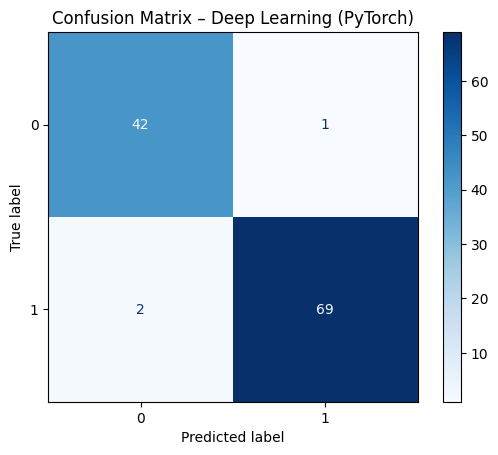

In [20]:
# ====================================
# Confusion matrix visualization
# ====================================

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[0, 1]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Deep Learning (PyTorch)")
plt.show()


### How to read these results

**Accuracy** provides a high-level summary:
- the proportion of correctly classified samples

However, accuracy alone
does not describe the full error structure.

### Confusion matrix

The confusion matrix shows:
- correct predictions
- false positives
- false negatives

It allows us to understand
*how* the model makes mistakes,
not just *how many*.

### Classification report

The classification report summarizes:
- precision
- recall
- F1-score
- support for each class

These metrics are especially important
when class distributions are uneven.

### Important note

The evaluation process is identical
to the one used for classical ML models.

This allows:
- direct comparison of results
- objective assessment of model behavior
- fair benchmarking across approaches

### Key takeaway

PyTorch models integrate seamlessly
with standard evaluation tools.

Once predictions are generated,
model assessment is framework-independent.

In the next section,
we will discuss **when to use**
this type of model and **when not to**.


__________________________
## 10. When to use it and when not to

Deep Learning with PyTorch is a powerful approach,
but it is not always the best choice.

Choosing this model depends on:
- problem complexity
- data size
- need for flexibility and control


### When to use Deep Learning with PyTorch

PyTorch is a good choice when:

- the relationship between features and classes is complex
- non-linear patterns are important
- you want full control over the training process
- custom architectures are required
- transparency of the learning process matters

It is especially useful for:
- research
- experimentation
- advanced model customization


### When NOT to use Deep Learning with PyTorch

PyTorch may not be ideal when:

- a simpler model achieves similar performance
- interpretability is a primary requirement
- development time must be minimal
- the dataset is small and simple

In these cases,
classical machine learning models
may be more efficient and easier to maintain.


### Practical warning signs

You should reconsider using PyTorch if:

- training is unstable or hard to debug
- performance gains are marginal
- model complexity grows unnecessarily
- simpler pipelines are easier to manage

Complexity should always be justified
by a clear performance or flexibility benefit.


### Key takeaway

PyTorch provides:
- maximum flexibility
- explicit control
- deep insight into the learning process

It is an excellent choice
when understanding and customizing neural networks
is as important as achieving high performance.

In the next section,
we will cover **model persistence**
and save the trained model for reuse.


_____________________________________
## 11. Model persistence

In this section we save the trained PyTorch model
and the preprocessing steps used during training.

Model persistence allows us to:
- reuse the model without retraining
- ensure reproducibility
- separate training from inference


In [21]:
# ====================================
# Model persistence (PyTorch)
# ====================================

# Define model directory
model_dir = Path("models/supervised_learning/classification/deep_learning_pytorch")

# Create directory if it does not exist
model_dir.mkdir(parents=True, exist_ok=True)

# Save model parameters (state_dict)
torch.save(model.state_dict(), model_dir / "pytorch_model_state_dict.pt")

# Save scaler (part of the preprocessing pipeline)
import joblib
joblib.dump(scaler, model_dir / "scaler.joblib")


['models\\supervised_learning\\classification\\deep_learning_pytorch\\scaler.joblib']

### What exactly we saved

For PyTorch models, we do **not** save the entire model object.

Instead, we save:
- the model's `state_dict`
- which contains all learned parameters (weights and biases)

This is the recommended and safest approach in PyTorch.

### Why we also save the scaler

Neural networks are highly sensitive
to the scale of input features.

The scaler is therefore:
- an essential part of the pipeline
- required to preprocess new data correctly

Saving the scaler guarantees
that future inputs are transformed
in exactly the same way as during training.

### How the model will be reused

To reuse the model later:
1. recreate the model architecture
2. load the saved `state_dict`
3. load the scaler
4. apply preprocessing
5. run predictions

This ensures full consistency
between training and inference.

At this point,
the PyTorch classification model
is fully trained, evaluated, and saved.


_________________
## 12. Mathematical formulation (deep dive)

This section provides a mathematical interpretation
of the PyTorch neural network used for classification.

The goal is to connect the code we wrote
with the underlying mathematical operations,
without introducing unnecessary complexity.


### Representation of the data

Each input sample is represented as a vector:

$$
x_i \in \mathbb{R}^d
$$

where:
- \( d \) is the number of input features
- each sample corresponds to one row in the dataset

The corresponding target label is:

$$
y_i \in \{0, 1\}
$$

The supervised dataset is:

$$
\{(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)\}
$$


### Linear transformation in a neural network layer

Each fully connected layer applies
a linear transformation of the form:

$$
z = W x + b
$$

where:
- \( x \) is the input vector
- \( W \) is the weight matrix
- \( b \) is the bias vector
- \( z \) is the pre-activation output

This operation is implemented in PyTorch
using `nn.Linear`.


### Non-linear activation

After each linear transformation,
a non-linear activation function is applied:

$$
a = \phi(z)
$$

In this notebook, we use ReLU:

$$
\phi(z) = \max(0, z)
$$

Non-linearity allows the network
to model complex decision boundaries.


### Layer composition

By stacking multiple layers,
the network performs a sequence of transformations:

$$
x \rightarrow h_1 \rightarrow h_2 \rightarrow \dots \rightarrow \hat{y}
$$

Each hidden layer learns
a more abstract representation
of the input data.


### Output layer and logits

The output layer produces raw scores,
called **logits**:

$$
\hat{y} = f(x)
$$

Each component of \( \hat{y} \)
corresponds to one class.

These values are **not probabilities**.


### From logits to probabilities

Class probabilities are obtained
by applying the softmax function:

$$
P(y = c \mid x) =
\frac{e^{\hat{y}_c}}{\sum_k e^{\hat{y}_k}}
$$

Softmax converts logits
into a probability distribution
over classes.


### Loss function

Training requires measuring prediction error.

This is done using a loss function:

$$
\mathcal{L}(y, \hat{y})
$$

For classification, the loss penalizes:
- incorrect class predictions
- low confidence in correct predictions

The loss is minimized during training.


### Gradient-based optimization

Model parameters are updated iteratively
using gradient descent:

$$
W \leftarrow W - \eta \nabla_W \mathcal{L}
$$

where:
- \( \eta \) is the learning rate
- gradients indicate how parameters should change

PyTorch computes gradients automatically
using backpropagation.


### Learning perspective

From a learning perspective:
- the model starts with random parameters
- predictions are initially inaccurate
- each update slightly improves the model

Training is a gradual process
of reducing prediction error.


### Final takeaway

The PyTorch neural network classifier:
- applies linear and non-linear transformations
- produces logits for classification
- learns by minimizing a loss function
- updates parameters via gradient-based optimization

This mathematical structure
directly corresponds to the code
written in the training loop.


___
## 13. Final summary – Code only

The following cell contains the complete classification pipeline
from data loading to model persistence.

No explanations are provided here on purpose.

This section is intended for:
- quick execution
- reference
- reuse in scripts or applications


In [ ]:
# ====================================
# Imports
# ====================================

import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

from pathlib import Path
import matplotlib.pyplot as plt
import joblib

import torch
import torch.nn as nn
import torch.optim as optim


# ====================================
# Dataset loading
# ====================================

data = load_breast_cancer(as_frame=True)

X = data.data
y = data.target


# ====================================
# Train-test split
# ====================================

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


# ====================================
# Feature scaling
# ====================================

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ====================================
# Convert to PyTorch tensors
# ====================================

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


# ====================================
# Model definition
# ====================================

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)
        return x


model = NeuralNetwork(input_dim=X_train_tensor.shape[1])


# ====================================
# Loss and optimizer
# ====================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# ====================================
# Training loop
# ====================================

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


# ====================================
# Predictions
# ====================================

model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1)
    y_pred_proba = torch.softmax(logits, dim=1)


# ====================================
# Model evaluation
# ====================================

y_test_np = y_test_tensor.numpy()
y_pred_np = y_pred.numpy()

accuracy = accuracy_score(y_test_np, y_pred_np)
cm = confusion_matrix(y_test_np, y_pred_np)

accuracy
cm

print(classification_report(y_test_np, y_pred_np))


# ====================================
# Confusion matrix visualization
# ====================================

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[0, 1]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Deep Learning (PyTorch)")
plt.show()


# ====================================
# Model persistence
# ====================================

model_dir = Path("models/supervised_learning/classification/deep_learning_pytorch")
model_dir.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), model_dir / "pytorch_model_state_dict.pt")
joblib.dump(scaler, model_dir / "scaler.joblib")
